# Career Trajectories

## 8.1 Introduction

This chapter analyzes career trajectories using batting data from the Lahman database. We'll examine how player performance changes over time, focusing on Mickey Mantle as a case study.

## 8.2 Mickey Mantle's Batting Trajectory

### Load Lahman data

Using the Lahman database to obtain season-by-season hitting statistics for Mickey Mantle.

In [1]:
import pandas as pd
import numpy as np

people = pd.read_csv('../data/lahman/People.csv')
batting = pd.read_csv('../data/lahman/Batting.csv')

Extract Mickey Mantle's playerID from the People data frame.

In [2]:
mantle_id = people.loc[
    (people['nameFirst'] == 'Mickey') & (people['nameLast'] == 'Mantle'),
    'playerID'
].iloc[0]

print(mantle_id)

mantlmi01


Certain statistics like SF (sacrifice flies) and HBP (hit by pitch) were not recorded for older seasons and are coded as `NaN`. Recode these missing values to 0.

In [3]:
batting = batting.fillna({'SF': 0, 'HBP': 0})

### Compute player age and statistics

Major League Baseball defines a player's age as their age on June 30 of that season. The `get_stats()` function computes:
- **Age**: Adjusted for birth month (if born July or later, add 1 to birth year)
- **SLG**: Slugging percentage
- **OBP**: On-base percentage  
- **OPS**: On-base plus slugging

In [4]:
def get_stats(player_id):
    player_batting = batting[batting['playerID'] == player_id].copy()
    
    player_info = people[people['playerID'] == player_id].iloc[0]
    
    # Adjust birth year if born in July or later
    birthyear = player_info['birthYear']
    if player_info['birthMonth'] >= 7:
        birthyear += 1
    
    player_batting['Age'] = player_batting['yearID'] - birthyear
    
    # Calculate slugging percentage (SLG)
    player_batting['SLG'] = (
        (player_batting['H'] - player_batting['2B'] - player_batting['3B'] - player_batting['HR'] + 
         2 * player_batting['2B'] + 
         3 * player_batting['3B'] + 
         4 * player_batting['HR']) / player_batting['AB']
    )
    
    # Calculate on-base percentage (OBP)
    player_batting['OBP'] = (
        (player_batting['H'] + player_batting['BB'] + player_batting['HBP']) / 
        (player_batting['AB'] + player_batting['BB'] + player_batting['HBP'] + player_batting['SF'])
    )
    
    # Calculate OPS
    player_batting['OPS'] = player_batting['SLG'] + player_batting['OBP']
    
    return player_batting[['Age', 'SLG', 'OBP', 'OPS']]

Apply the function to get Mickey Mantle's career statistics.

In [5]:
mantle_stats = get_stats(mantle_id)
mantle_stats

,Age,SLG,OBP,OPS
70266,19.0,0.442815,0.348958,0.791774
70267,20.0,0.530055,0.394231,0.924285
70268,21.0,0.496746,0.398148,0.894894
70269,22.0,0.524862,0.408320,0.933182
70270,23.0,0.611219,0.430818,1.042036
70271,24.0,0.705441,0.463902,1.169343
70272,25.0,0.664557,0.512039,1.176595
70273,26.0,0.591522,0.443252,1.034774
70274,27.0,0.513863,0.390282,0.904145
70275,28.0,0.557875,0.399068,0.956943


### Plotting OPS vs Age

OPS (on-base plus slugging) is a comprehensive measure of batting performance. Plotting OPS against age reveals how Mantle's performance changed throughout his career.

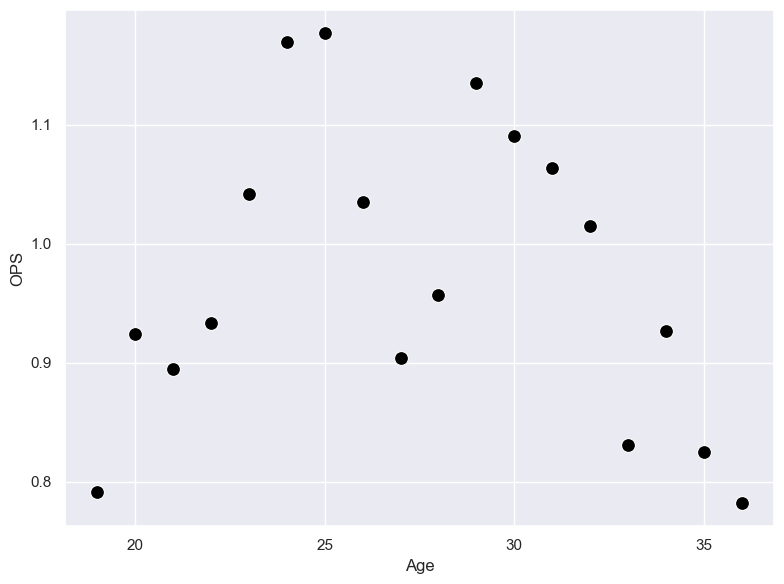

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid', palette='deep')

fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(data=mantle_stats, x='Age', y='OPS', s=100, color='black', ax=ax)

ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('OPS', fontsize=12)
ax.set_xticks([20, 25, 30, 35])
ax.set_yticks([0.8, 0.9, 1.0, 1.1])

plt.tight_layout()
plt.show()

### Fitting a Quadratic Model

A quadratic curve models the career trajectory, where performance increases to a peak age and then declines. The model is:

$$\text{OPS} \sim (Age - 30) + (Age - 30)^2$$

This centers the age variable at 30, making coefficients easier to interpret.

In [7]:
import statsmodels.api as sm

def fit_model(d):
    # Create centered age variables
    d = d.copy()
    d['Age_centered'] = d['Age'] - 30
    d['Age_squared'] = (d['Age'] - 30) ** 2
    
    # Prepare features with intercept
    X = sm.add_constant(d[['Age_centered', 'Age_squared']])
    y = d['OPS']
    
    # Fit the model
    fit = sm.OLS(y, X).fit()
    
    # Calculate peak metrics
    b0 = fit.params['const']
    b1 = fit.params['Age_centered']
    b2 = fit.params['Age_squared']
    Age_max = 30 - b1 / b2 / 2
    Max = b0 - b1 ** 2 / b2 / 4
    
    return {'fit': fit, 'Age_max': Age_max, 'Max': Max}

Fit the quadratic model to Mantle's career data.

In [8]:
mantle_fit = fit_model(mantle_stats)

print(mantle_fit['fit'].params)

const           1.043134
Age_centered   -0.022883
Age_squared    -0.003869
dtype: float64


In [9]:
print(f"Age at peak: {mantle_fit['Age_max']:.2f}")
print(f"Maximum OPS: {mantle_fit['Max']:.2f}")

Age at peak: 27.04
Maximum OPS: 1.08


The best fitting curve is given by:
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mn>1.04313</mn>
  <mo>&#x2212;</mo>
  <mn>0.02288</mn>
  <mo stretchy="false">(</mo>
  <mi>A</mi>
  <mi>g</mi>
  <mi>e</mi>
  <mo>&#x2212;</mo>
  <mn>30</mn>
  <mo stretchy="false">)</mo>
  <mo>&#x2212;</mo>
  <mn>0.00387</mn>
  <mo stretchy="false">(</mo>
  <mi>A</mi>
  <mi>g</mi>
  <mi>e</mi>
  <mo>&#x2212;</mo>
  <mn>30</mn>
  <msup>
    <mo stretchy="false">)</mo>
    <mn>2</mn>
  </msup>
  <mstyle scriptlevel="0">
    <mspace width="0.167em"></mspace>
  </mstyle>
</math>

Mantle's peak: age 27, OPS 1.08. The curvature parameter (-0.00387) shows OPS declined ~0.004 per year after peak performance.

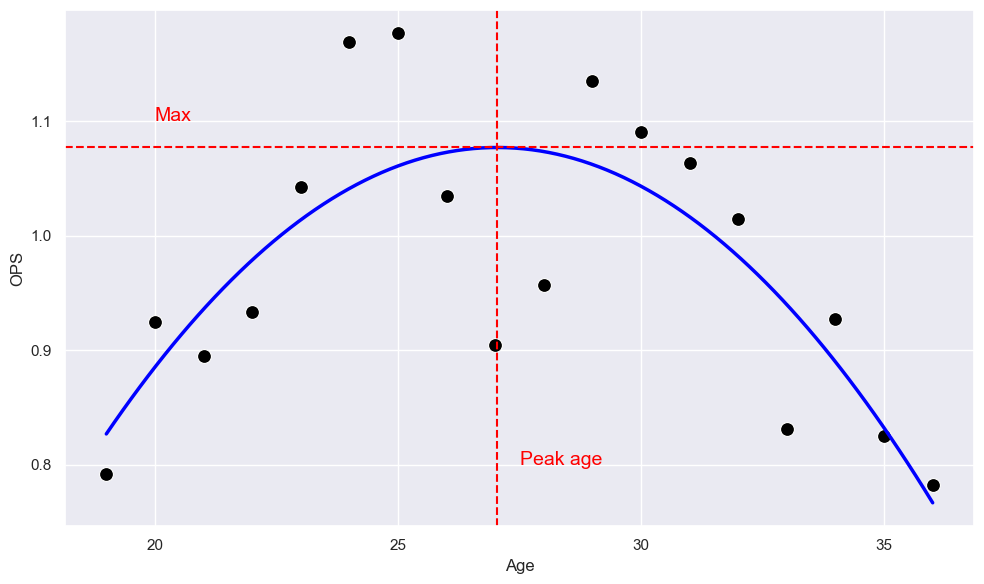

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot of actual data
sns.scatterplot(data=mantle_stats, x='Age', y='OPS', s=100, color='black', ax=ax)

# Generate predictions for smooth curve
age_range = np.linspace(mantle_stats['Age'].min(), mantle_stats['Age'].max(), 100)
age_centered = age_range - 30
age_squared = age_centered ** 2

# Create prediction dataframe with constant term
X_pred = pd.DataFrame({
    'Age_centered': age_centered,
    'Age_squared': age_squared
})
X_pred = sm.add_constant(X_pred)

ops_pred = mantle_fit['fit'].predict(X_pred)

# Plot fitted curve
ax.plot(age_range, ops_pred, color='blue', linewidth=2.5)

# Add vertical line for peak age
ax.axvline(x=mantle_fit['Age_max'], color='red', linestyle='--')

# Add horizontal line for max OPS
ax.axhline(y=mantle_fit['Max'], color='red', linestyle='--')

# Add annotations
ax.text(27.5, 0.8, 'Peak age', color='red', fontsize=14)
ax.text(20, 1.1, 'Max', color='red', fontsize=14)

ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('OPS', fontsize=12)
ax.set_xticks([20, 25, 30, 35])
ax.set_yticks([0.8, 0.9, 1.0, 1.1])

plt.tight_layout()
plt.show()


In [11]:
mantle_fit['fit'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    OPS   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     11.34
Date:                Sun, 28 Dec 2025   Prob (F-statistic):            0.00100
Time:                        01:21:36   Log-Likelihood:                 20.640
No. Observations:                  18   AIC:                            -35.28
Df Residuals:                      15   BIC:                            -32.61
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.0431      0.028     37.387      0.000       0.984       1.103
Age_centered    -0.0229      0.006     -4.059      0.001      -0.035      -0.011
Age_squared     -0.0039      0.001     -4.671      0.000      -0.006      -0.002
==============================================================================
Omnibus:                        1.098   Durbin-Watson:                   1.438
Prob(Omnibus):                  0.577   Jarque-Bera (JB):                0.721
Skew:                          -0.472   Prob(JB):                        0.697
Kurtosis:                       2.738   Cond. No.                         68.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
print(f"Residual Standard Error: {np.sqrt(mantle_fit['fit'].mse_resid)}")

Residual Standard Error: 0.08420947610713088


R² = 0.602 the model explains 60% of OPS variability. The residual standard error of 0.084 indicates that approximately 68% of the model's predictions fall within ±0.084 OPS of the actual values.



## 8.3 Comparing Trajectories

### 8.3.1 Some preliminary work

In [13]:
# Calculate career at-bats for each player
career_ab = batting.groupby('playerID')['AB'].sum().reset_index()
career_ab.columns = ['playerID', 'AB_career']

# Join with batting data and filter for players with >= 2000 career AB
batting_2000 = career_ab.merge(batting, on='playerID')
batting_2000 = batting_2000[batting_2000['AB_career'] >= 2000]


In [14]:
# Load fielding data
fielding = pd.read_csv('../data/lahman/Fielding.csv')

# For each player and position, sum total games played
positions = (fielding
    .groupby(['playerID', 'POS'])['G']
    .sum()
    .reset_index()
    .rename(columns={'G': 'Games'})
)

# Sort by playerID and Games (descending) to get primary position
positions = positions.sort_values(['playerID', 'Games'], ascending=[True, False])

# Keep only the first (most-played) position for each player
positions = positions.groupby('playerID').first().reset_index()

In [15]:
# Merge primary position with batting data for 2000+ AB players
batting_2000 = batting_2000.merge(
    positions[['playerID', 'POS', 'Games']], 
    on='playerID', 
    how='inner')

### 8.3.2 Computing career statistics

In [16]:
# Define variables to sum across each player's career
my_vars = ['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'BB', 'SO', 'SB']

# Group by player and sum all career statistics
c_totals = (batting_2000
    .groupby('playerID')[my_vars]
    .sum()
    .reset_index()
)

c_totals.head()

,playerID,G,AB,R,H,2B,3B,HR,RBI,BB,SO,SB
0,aaronha01,3298,12364,2174,3771,624,98,755,2297.0,1402,1383.0,240.0
1,abbated01,855,3044,355,772,99,43,11,324.0,289,283.0,142.0
2,abbotku01,702,2044,273,523,109,23,62,242.0,133,571.0,22.0
3,abreubo01,2425,8480,1453,2470,574,59,288,1363.0,1476,1840.0,400.0
4,abreujo02,1446,5607,769,1587,328,17,263,960.0,432,1246.0,11.0


In [17]:
# Calculate career batting average and slugging percentage
c_totals['AVG'] = c_totals['H'] / c_totals['AB']
c_totals['SLG'] = (
    (c_totals['H'] - c_totals['2B'] - c_totals['3B'] - c_totals['HR'] +
     2 * c_totals['2B'] + 
     3 * c_totals['3B'] + 
     4 * c_totals['HR']) / c_totals['AB']
)

c_totals.head()

,playerID,G,AB,R,H,2B,3B,HR,RBI,BB,SO,SB,AVG,SLG
0,aaronha01,3298,12364,2174,3771,624,98,755,2297.0,1402,1383.0,240.0,0.304998,0.554513
1,abbated01,855,3044,355,772,99,43,11,324.0,289,283.0,142.0,0.253614,0.325230
2,abbotku01,702,2044,273,523,109,23,62,242.0,133,571.0,22.0,0.255871,0.422701
3,abreubo01,2425,8480,1453,2470,574,59,288,1363.0,1476,1840.0,400.0,0.291274,0.474764
4,abreujo02,1446,5607,769,1587,328,17,263,960.0,432,1246.0,11.0,0.283039,0.488318


In [18]:
# Merge career statistics with primary fielding positions
c_totals = c_totals.merge(positions[['playerID', 'POS']], on='playerID', how='inner')

# Assign Bill James position values for similarity scores
# Higher values = more defensively demanding positions
position_values = {
    'C': 240,   # Catcher
    'SS': 168,  # Shortstop
    '2B': 132,  # Second base
    '3B': 84,   # Third base
    'OF': 48,   # Outfield
    '1B': 12,   # First base
}

c_totals['Value_POS'] = c_totals['POS'].map(position_values).fillna(0)

### 8.3.3 Computing similarity scores

In [19]:
def similar(p, number=10):
    # Get the target player's statistics
    P = c_totals[c_totals['playerID'] == p].iloc[0]
    
    # Calculate similarity score for all players
    result = c_totals.copy()
    
    result['sim_score'] = (
        1000 -
        np.floor(np.abs(result['G'] - P['G']) / 20) -
        np.floor(np.abs(result['AB'] - P['AB']) / 75) -
        np.floor(np.abs(result['R'] - P['R']) / 10) -
        np.floor(np.abs(result['H'] - P['H']) / 15) -
        np.floor(np.abs(result['2B'] - P['2B']) / 5) -
        np.floor(np.abs(result['3B'] - P['3B']) / 4) -
        np.floor(np.abs(result['HR'] - P['HR']) / 2) -
        np.floor(np.abs(result['RBI'] - P['RBI']) / 10) -
        np.floor(np.abs(result['BB'] - P['BB']) / 25) -
        np.floor(np.abs(result['SO'] - P['SO']) / 150) -
        np.floor(np.abs(result['SB'] - P['SB']) / 20) -
        np.floor(np.abs(result['AVG'] - P['AVG']) / 0.001) -
        np.floor(np.abs(result['SLG'] - P['SLG']) / 0.002) -
        np.abs(result['Value_POS'] - P['Value_POS'])
    )
    
    # Sort by similarity score (descending) and return top N
    return result.sort_values('sim_score', ascending=False).head(number)

In [20]:
similar(mantle_id, 6)

,playerID,G,AB,R,H,2B,3B,HR,RBI,BB,SO,SB,AVG,SLG,POS,Value_POS,sim_score
1511,mantlmi01,2401,8102,1677,2415,344,72,536,1509.0,1733,1710.0,153.0,0.298075,0.556776,OF,48.0,1000.0
2388,thomafr04,2322,8199,1494,2468,495,12,521,1704.0,1667,1397.0,32.0,0.301012,0.554946,1B,12.0,856.0
1544,matheed01,2391,8537,1509,2315,354,72,512,1453.0,1444,1487.0,68.0,0.271173,0.509430,3B,84.0,853.0
2139,schmimi01,2404,8352,1506,2234,408,59,548,1595.0,1507,1883.0,174.0,0.267481,0.527299,3B,84.0,848.0
2185,sheffga01,2576,9217,1636,2689,467,27,509,1676.0,1475,1171.0,253.0,0.291744,0.513942,OF,48.0,847.0
2254,sosasa01,2354,8813,1475,2408,379,45,609,1667.0,929,2306.0,234.0,0.273233,0.533757,OF,48.0,831.0


Five players most similar to Mantle: Frank Thomas, Eddie Mathews, Mike Schmidt, Gary Sheffield, and Sammy Sosa.

### 8.3.4 Defining age, OBP, SLG, and OPS variables

In [21]:
# Combine multiple team stints into single season rows for each player
# (Players who were traded mid-season have separate rows per team)
batting_2000 = (batting_2000
    .groupby(['playerID', 'yearID'], as_index=False)
    .agg({
        'G': 'sum',
        'AB': 'sum',
        'R': 'sum',
        'H': 'sum',
        '2B': 'sum',
        '3B': 'sum',
        'HR': 'sum',
        'RBI': 'sum',
        'SB': 'sum',
        'CS': 'sum',
        'BB': 'sum',
        'SH': 'sum',
        'SF': 'sum',
        'HBP': 'sum',
        'AB_career': 'first',
        'POS': 'first'
    })
)

# Calculate season slugging, on-base, and OPS
batting_2000['SLG'] = (
    (batting_2000['H'] - batting_2000['2B'] - batting_2000['3B'] - batting_2000['HR'] +
     2 * batting_2000['2B'] + 
     3 * batting_2000['3B'] + 
     4 * batting_2000['HR']) / batting_2000['AB']
)

batting_2000['OBP'] = (
    (batting_2000['H'] + batting_2000['BB'] + batting_2000['HBP']) / 
    (batting_2000['AB'] + batting_2000['BB'] + batting_2000['HBP'] + batting_2000['SF'])
)

batting_2000['OPS'] = batting_2000['SLG'] + batting_2000['OBP']

In [22]:
# Merge with People table to get birth information
batting_2000 = batting_2000.merge(
    people[['playerID', 'birthYear', 'birthMonth']], 
    on='playerID', 
    how='inner'
)

# Calculate MLB birth year (add 1 if born July or later)
batting_2000['Birthyear'] = batting_2000.apply(
    lambda row: row['birthYear'] + 1 if row['birthMonth'] >= 7 else row['birthYear'],
    axis=1
)

# Calculate age for each season
batting_2000['Age'] = batting_2000['yearID'] - batting_2000['Birthyear']

In [24]:
# Remove records where Age is missing (mainly 19th century players with unknown birth years)
batting_2000 = batting_2000.dropna(subset=['Age'])

### 8.3.5 Fitting and plotting trajectories

In [ ]:
def plot_trajectories(player, n_similar=5, ncol=2):
    # Split name and find player ID
    first_name, last_name = player.split(' ', 1)
    
    player_id = people.loc[
        (people['nameFirst'] == first_name) & (people['nameLast'] == last_name),
        'playerID'
    ].iloc[0]
    
    # Get list of similar players
    player_list = similar(player_id, n_similar)['playerID'].tolist()
    
    # Filter batting data for similar players
    batting_new = batting_2000[batting_2000['playerID'].isin(player_list)].copy()
    
    # Add full names
    batting_new = batting_new.merge(
        people[['playerID', 'nameFirst', 'nameLast']], 
        on='playerID', 
        how='left'
    )
    batting_new['Name'] = batting_new['nameFirst'] + ' ' + batting_new['nameLast']
    
    # Create faceted plot with quadratic regression
    grid = sns.FacetGrid(batting_new, col='Name', col_wrap=ncol, 
                      height=4, aspect=1.2, sharey=True)
    
    def plot_quadratic(data, **kwargs):
        # Fit quadratic model
        X = sm.add_constant(np.column_stack([data['Age'], data['Age']**2]))
        y = data['OPS']
        model = sm.OLS(y, X).fit()
        
        # Generate predictions
        age_range = np.linspace(data['Age'].min(), data['Age'].max(), 100)
        X_pred = sm.add_constant(np.column_stack([age_range, age_range**2]))
        ops_pred = model.predict(X_pred)
        
        # Plot with confidence interval
        plt.plot(age_range, ops_pred, color='blue', linewidth=2)
        plt.fill_between(age_range, 
                        ops_pred - 0.05, ops_pred + 0.05,
                        alpha=0.2, color='blue')
    
    grid.map_dataframe(plot_quadratic)
    grid.set_axis_labels('Age', 'OPS')
    grid.set_titles("{col_name}")
    
    plt.tight_layout()
    return grid


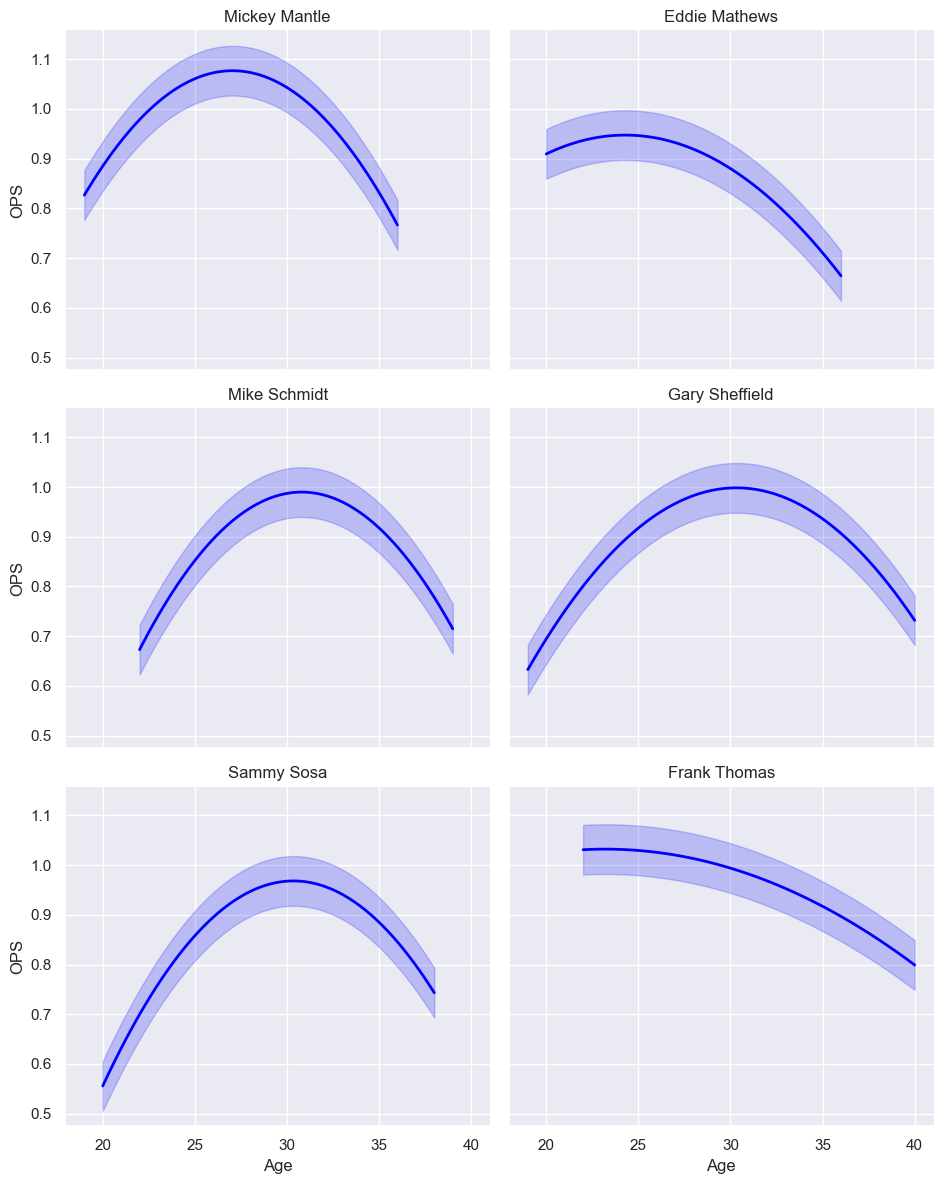

In [26]:
plot_trajectories("Mickey Mantle", 6, 2)
plt.show()

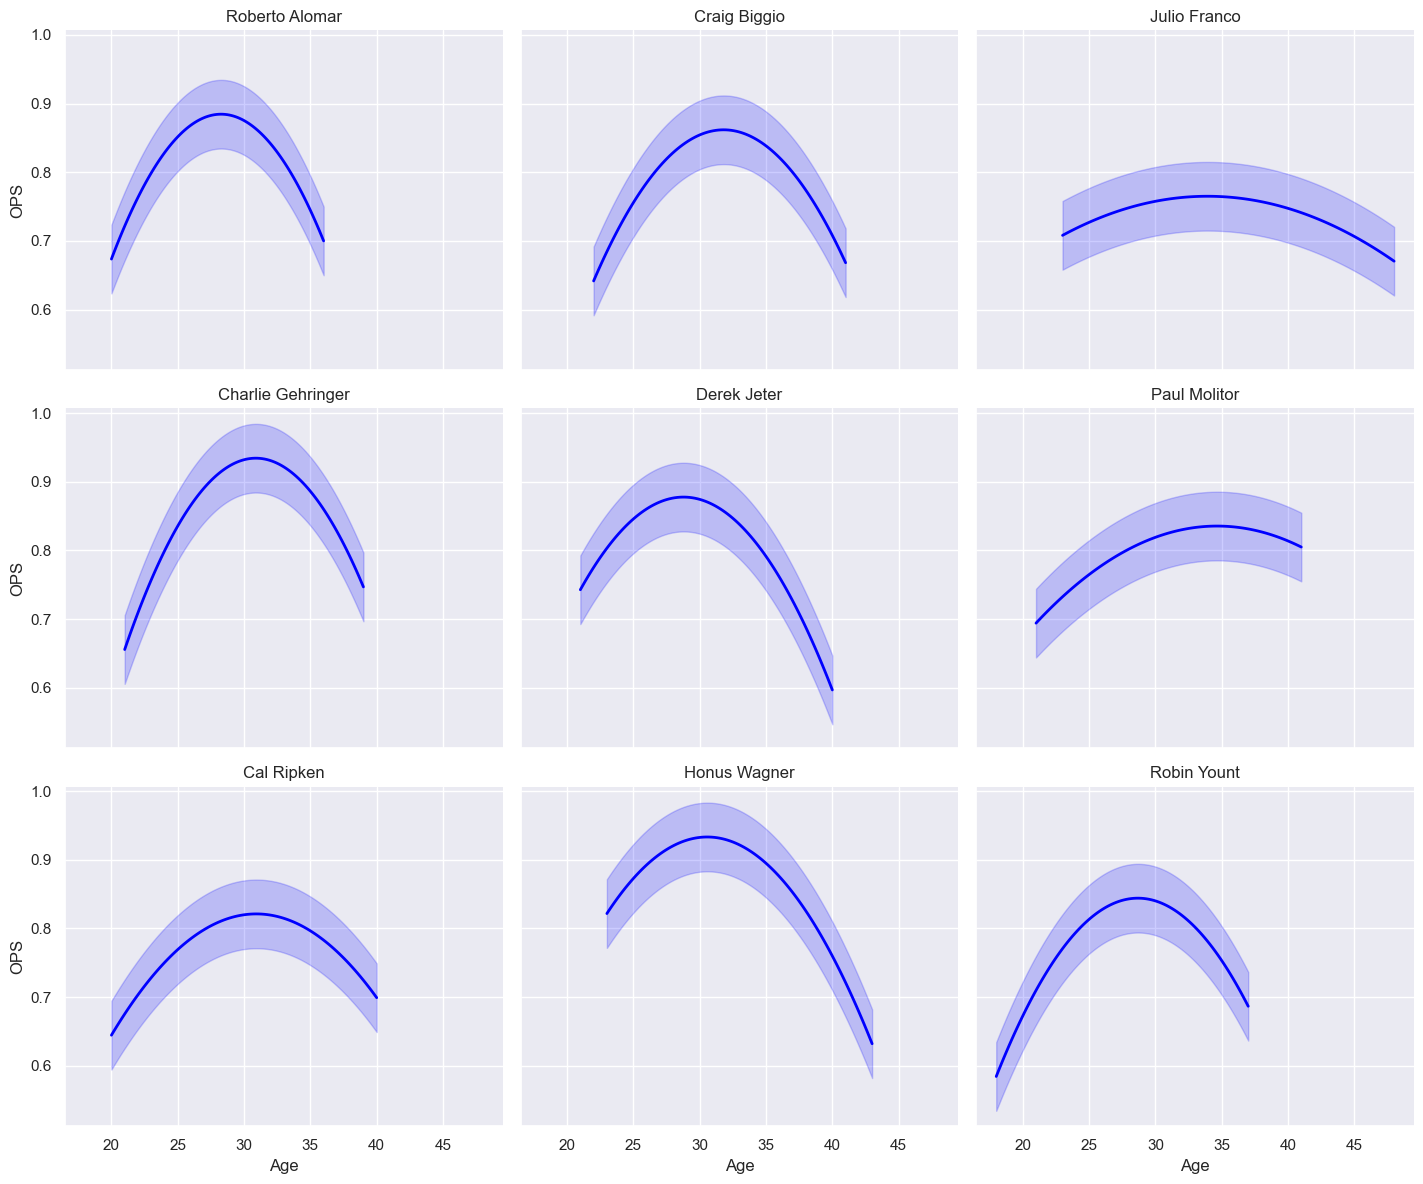

In [28]:
plot_trajectories("Derek Jeter", 9, 3)
plt.show()